In [14]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime


import static_nda as nda
from itertools import chain
from pipeline import meso,collection,experiment
from scipy.interpolate import interp1d
from stimulus import stimulus


# Scan Parameters

In [4]:
print('nfields: ', set((meso.ScanInfo & nda.Scan.proj()).fetch('nfields')))
print('fps: ',set((meso.ScanInfo & nda.Scan.proj()).fetch('fps')))

print([p+': '+str(set((meso.ScanInfo.Field & nda.Scan.proj()).fetch(p))) 
       for p in ('px_height','px_width','um_height','um_width')])

print('z spacing: ', set(chain(*[set(np.diff(sorted((meso.ScanInfo.Field & scan_key).fetch('z'))))
                                 for scan_key in nda.Scan.proj()])))

min_depths = (nda.Scan.proj().aggr(meso.ScanInfo.Field & nda.Scan.proj(),min_depth='MIN(z)')).fetch('min_depth')
print('first plane ranging from: ', str(min(min_depths)), '-', str(max(min_depths)), 'um from surface')   


nfields:  {10}
fps:  {7.97908}
['px_height: {252}', 'px_width: {252}', 'um_height: {630.0}', 'um_width: {630.0}']
z spacing:  {5.0}
first plane ranging from:  193.0 - 218.0 um from surface


# Laser Power Calibration Curves

,curve_date,mWs,p2mW,percs
0,2018-03-27,"[5, 16, 29, 40, 52, 63, 74, 84, 95, 105, 113]",<scipy.interpolate.interpolate.interp1d object...,"[1.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
1,2019-01-01,"[1.7, 10, 19, 28, 36, 44, 52, 60, 63, 74, 80]",<scipy.interpolate.interpolate.interp1d object...,"[0.8, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
2,2019-06-13,"[2.9, 15, 27, 39, 51, 59, 72, 83, 92, 102, 110]",<scipy.interpolate.interpolate.interp1d object...,"[0.8, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
3,2019-11-01,"[1.9, 10.8, 20, 28.8, 37.5, 46.1, 54.5, 60.7, ...",<scipy.interpolate.interpolate.interp1d object...,"[0.7, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
4,2021-01-25,"[3.3, 16, 28, 41, 52, 64, 75, 87, 97, 104, 106]",<scipy.interpolate.interpolate.interp1d object...,"[0.7, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
5,2021-11-30,"[7.4, 13.8, 20.1, 26.5, 32.7, 39, 45, 51, 57.3...",<scipy.interpolate.interpolate.interp1d object...,"[5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0..."


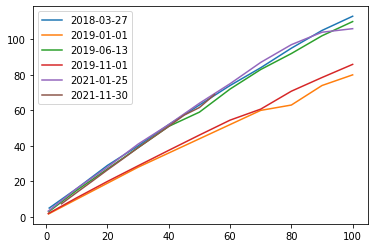

In [9]:
curve_df = pd.DataFrame()

# meso power curve, 3/27/2018
date = datetime.date(2018,3,27)
percs = np.linspace(0,100,11)
percs[0]=1
mWs = [5,16,29,40,52,63,74,84,95,105,113]
p2mW = interp1d(percs,mWs)
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve 1/?/2019
date = datetime.date(2019,1,1)
percs = np.linspace(0,100,11)
percs[0]=0.8
mWs = [1.7,10,19,28,36,44,52,60,63,74,80]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 6/13/2019
date = datetime.date(2019,6,13)
percs = np.linspace(0,100,11)
percs[0] = 0.8
mWs = [2.9,15,27,39,51,59,72,83,92,102,110]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 11/1/2019
date = datetime.date(2019,11,1)
percs = np.linspace(0,100,11)
percs[0]=0.7
mWs = [1.9,10.8,20,28.8,37.5,46.1,54.5,60.7,70.8,78.5,85.9]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 1/25/2021
date = datetime.date(2021,1,25)
percs = np.linspace(0,100,11)
percs[0]=0.7
mWs = [3.3,16,28,41,52,64,75,87,97,104,106]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 11/30/2021
date = datetime.date(2021,11,30)
percs = np.linspace(5,55,11)
mWs = [7.4,13.8,20.1,26.5,32.7,39,45,51,57.3,61.6,69]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)


display(curve_df)

fig,ax = plt.subplots()
for d,p,mW in zip(curve_df['curve_date'],curve_df['percs'],curve_df['mWs']):
    ax.plot(p,mW,label=d)
ax.legend()

# Estimated Power Usage

In [15]:
# est_df = [{'animal_id':21067, 'session':9,  'scan_idx':17, 'est_power':28, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':21067, 'session':10, 'scan_idx':18, 'est_power':28, 'est_power_depth':218, 'est_Lz':220},
#           {'animal_id':21067, 'session':13, 'scan_idx':14, 'est_power':25, 'est_power_depth':212, 'est_Lz':220},
#           {'animal_id':22620, 'session':4,  'scan_idx':15, 'est_power':22, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':22620, 'session':4,  'scan_idx':17, 'est_power':22, 'est_power_depth':197, 'est_Lz':220},
#           {'animal_id':22620, 'session':5,  'scan_idx':11, 'est_power':22, 'est_power_depth':201, 'est_Lz':220},
#           {'animal_id':22846, 'session':2,  'scan_idx':19, 'est_power':25, 'est_power_depth':210, 'est_Lz':220},
#           {'animal_id':22846, 'session':2,  'scan_idx':21, 'est_power':25, 'est_power_depth':207, 'est_Lz':220},
#           {'animal_id':22846, 'session':7,  'scan_idx':15, 'est_power':22, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':22846, 'session':10, 'scan_idx':16, 'est_power':20, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':23343, 'session':5,  'scan_idx':17, 'est_power':18, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':23555, 'session':5,  'scan_idx':12, 'est_power':20, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':23656, 'session':14, 'scan_idx':22, 'est_power':20, 'est_power_depth':193, 'est_Lz':220},
#           {'animal_id':23964, 'session':4,  'scan_idx':22, 'est_power':20, 'est_power_depth':200, 'est_Lz':220}]
# est_df = pd.DataFrame(est_df)
# display(est_df)

def laser_power(z,z0,Lz,P0):
    return P0 * np.exp((z-z0)/Lz)
def depth_at_power(P,P0,Lz,z0):
    return log(P/P0) * Lz + z0

scanimage_df = []
for scan in nda.Scan.proj():
    date = (experiment.Session & scan).fetch1('session_date')
    scan_filename = (experiment.Scan() & scan).local_filenames_as_wildcard
    scan_filename = scan_filename.replace('*','_00001')
    t = tifffile.TiffFile(scan_filename)
    Lz = t.scanimage_metadata['FrameData']['SI.hBeams.lengthConstants']
    P0 = t.scanimage_metadata['FrameData']['SI.hBeams.powers']
    min_z = min((meso.ScanInfo.Field & scan).fetch('z'))
    max_z = max((meso.ScanInfo.Field & scan).fetch('z'))
    
    time_diff = list(date-curve_df['curve_date'])
    min_diff = min(i for i in time_diff if i > timedelta(0))
    curve_idx = time_diff.index(min_diff)
    curve_info = curve_df.loc[[curve_idx]]
    
    
    scanimage_df.append({**scan,'curve_date':curve_df.loc[curve_idx,'curve_date'],
                         'mw_at_first_plane':np.round(curve_df.loc[curve_idx,'p2mW'](P0),2),
                         'mw_at_last_plane':np.round(curve_df.loc[curve_idx,'p2mW'](laser_power(max_z,min_z,Lz,P0)),2),
                         'mw_at_zero':np.round(curve_df.loc[curve_idx,'p2mW'](laser_power(0,min_z,Lz,P0)),2),
                         'date':date,'scanimage_Lz':Lz, 
                         'scanimage_perc_at_first_plane':P0, 
                         'scanimage_min_z':min_z, 'scanimage_max_z':max_z})
    
#     scanimage_df.append({**scan,'Lz':Lz, 'perc_at_zero':P0,'mw_at_zero':np.round(p2mW(P0),2),
#                           'depth_of_max_power':np.round(depth_at_power(mW2p(np.max(mWs)),P0,Lz,0),2)})
scanimage_df = pd.DataFrame(scanimage_df)
display(scanimage_df)

,animal_id,session,scan_idx,curve_date,mw_at_first_plane,mw_at_last_plane,mw_at_zero,date,scanimage_Lz,scanimage_perc_at_first_plane,scanimage_min_z,scanimage_max_z
0,21067,9,17,2019-01-01,37.8,45.23,17.67,2019-04-02,220,28,200.0,245.0
1,21067,10,18,2019-01-01,37.8,45.23,16.51,2019-04-03,220,28,218.0,263.0
2,21067,13,14,2019-01-01,37.8,45.23,16.89,2019-04-08,220,28,212.0,257.0
3,22620,4,15,2019-06-13,31.2,36.69,14.61,2019-10-07,220,22,200.0,245.0
4,22620,4,17,2019-06-13,31.2,36.69,14.76,2019-10-07,220,22,197.0,242.0
5,22620,5,11,2019-06-13,31.2,36.69,14.56,2019-10-08,220,22,201.0,246.0
6,22846,2,19,2019-11-01,34.5,40.81,15.54,2019-11-07,220,25,210.0,255.0
7,22846,2,21,2019-11-01,34.5,40.81,15.70,2019-11-07,220,25,207.0,252.0
8,22846,7,15,2019-11-01,31.2,36.69,14.86,2019-11-26,220,22,195.0,240.0
9,22846,10,16,2019-11-01,29.0,33.99,13.63,2019-12-04,220,20,200.0,245.0


# Photodiode Collection and Alignment

# Two Photon Functional Imaging

In [20]:
fts = (stimulus.Sync & scan).fetch1('frame_times')

In [23]:
stimulus.Sync & scan

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,signal_start_time start of analog signal recording on stimulus clock,signal_duration (secs) duration of analog signal recording,frame_times start of each scanimage slice on stimulus clock,sync_ts
26645,2,18,1639520951.6597757,7445.8009322512,=BLOB=,2021-12-14 18:41:11


In [22]:
fts[-1]-fts[0]

7436.622280597687

In [ ]:
total_durations = []
for scan in nda.Scan():
    ft = (stimulus.Sync & scan).fetch1('frame_times')
    duration = ft[-1] - ft[0]
    n_traces = len(nda.Oracle)

In [14]:
total_durations = []
for scan in nda.ScanInclude():
    f1t = (nda.DepthTimes & scan).fetch1('field1_times')
    duration = f1t[-1] - f1t[0]
    n_traces = len(nda.Oracle() & scan)
    print(duration,n_traces,n_traces*duration)
    total_durations.append(n_traces*duration)

print('\n',np.sum(total_durations)/60/60)

6350.637286623 7493 47585325.18866614
6351.3603273749995 8592 54570887.93280599
6351.4113792732 8138 51687785.8045253
6350.4690897008 8158 51807126.83377913
6350.6923253334 8221 52209041.60656588
6350.84102434235 7971 50622553.80503287
6350.94900596755 7887 50089934.81006607
6350.8651231438 8618 54731755.631253265
6351.217085652251 11201 71139982.57639086
6351.45142599665 8194 52043792.98461655
6351.13351166755 9941 63136618.23948711
5804.40399374775 7973 46278513.04215081
5804.6378543529 7855 45595430.34594203
5926.5476758205 5130 30403189.576959167

 200528.31621617812


# Pre and post stimulus blanking

In [4]:
buffer_df = []
for scan in nda.Scan():
    dts = (nda.DepthTimes & scan).fetch1('depth_times')
    scan_start,scan_end = np.nanmin(dts),np.nanmax(dts)
    stim_start = (nda.Trial & scan).fetch('start_frame_time',order_by='start_frame_time ASC',limit=1)[0]
    stim_end = (nda.Trial & scan).fetch('end_frame_time',order_by = 'end_frame_time DESC',limit=1)[0]
    buffer_df.append({'session':scan['session'],
                      'scan_idx':scan['scan_idx'],
                      'scan_start':np.round(scan_start,2), 
                      'stim_start':np.round(stim_start,2),
                      'start_diff(s)':np.round(stim_start-scan_start,2),
                      'start_diff(m)':np.round((stim_start-scan_start)/60,2),
                      'scan_end':np.round(scan_end,2),
                      'stim_end':np.round(stim_end,2),
                      'end_diff(s)':np.round(scan_end-stim_end,2),
                      'end_diff(m)':np.round((scan_end-stim_end)/60,2)})
buffer_df = pd.DataFrame(buffer_df)  
print('pre-stimulus blanking: ', np.min(buffer_df['start_diff(m)']),'-',np.max(buffer_df['start_diff(m)']),' min')
print('post-stimulus blanking: ',np.min(buffer_df['end_diff(m)']),  '-',np.max(buffer_df['end_diff(m)']),' min')
display(buffer_df)
    

pre-stimulus blanking:  0.15 - 5.54  min
post-stimulus blanking:  8.26 - 21.2  min


,session,scan_idx,scan_start,stim_start,start_diff(s),start_diff(m),scan_end,stim_end,end_diff(s),end_diff(m)
0,4,7,0.0,8.70,8.70,0.15,6350.76,5079.04,1271.72,21.20
1,4,9,0.0,8.79,8.79,0.15,5574.90,5079.51,495.40,8.26
2,4,10,0.0,199.62,199.62,3.33,6351.17,5270.07,1081.09,18.02
3,5,3,0.0,332.37,332.37,5.54,6350.90,5402.55,948.35,15.81
4,5,6,0.0,196.25,196.25,3.27,6351.48,5266.75,1084.73,18.08
5,5,7,0.0,202.05,202.05,3.37,6351.53,5272.35,1079.18,17.99
6,6,2,0.0,290.48,290.48,4.84,6350.59,5362.61,987.98,16.47
7,6,4,0.0,194.02,194.02,3.23,6350.81,5264.70,1086.11,18.10
8,6,6,0.0,8.83,8.83,0.15,6350.96,5079.36,1271.60,21.19
9,6,7,0.0,222.33,222.33,3.71,6351.07,5292.94,1058.12,17.64


In [5]:
sync_df = []
for scan in list(nda.Scan()):
    behavior_path = (experiment.Session & {'animal_id':17797,**scan}).fetch1('behavior_path')
    local_path = lab.Paths().get_local_path(behavior_path)
    filename = (experiment.Scan.BehaviorFile() & {'animal_id':17797,**scan}).fetch1('filename')
    full_filename = os.path.join(local_path, filename)

    data = h5.read_behavior_file(full_filename)

    photodiode_times = h5.ts2sec(data['ts'], is_packeted=True)
    photodiode = data['syncPd']
    photodiode_freq = 1/np.nanmedian(np.diff(photodiode_times))
    
    trial_rel = (stimulus.Trial & {'animal_id':17797, **scan})
    first_trial_flip = trial_rel.fetch('flip_times',order_by='trial_idx ASC',limit=1)[0][0][0]
    last_trial_flip = trial_rel.fetch('flip_times',order_by='trial_idx DESC',limit=1)[0][0][-1]
    
    sync_trace,photodiode_start = (stimulus.Sync & {'animal_id':17797, **scan}).fetch1('frame_times','signal_start_time')
    if not(scan['session'] == 4 and scan['scan_idx'] == 9):
        sync_trace = sync_trace[0]
    sync_start,sync_end = sync_trace[0],sync_trace[-1]
    
    


    
    sync_df.append({'session':scan['session'],
                    'scan_idx':scan['scan_idx'],
                    'photodiode_times':photodiode_times,
                    'photodiode':photodiode,
                    'photodiode_freq':photodiode_freq,
                    'photodiode_start':photodiode_start,
                    'first_trial_flip':first_trial_flip,
                    'last_trial_flip':last_trial_flip,
                    'sync_trace':sync_trace,
                    'sync_start':sync_start,
                    'sync_end':sync_end})
sync_df = pd.DataFrame(sync_df)

# signal_start_times = []
# for _,r in sync_df.iterrows():
#     scan_key = {'animal_id':17797, **{v:r[v] for v in ['session','scan_idx']}}
#     signal_start_times.append((stimulus.Sync & scan_key).fetch1('signal_start_time'))
    

photodiode recording frequencies:  9999.95  -  10000.0  Hz


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


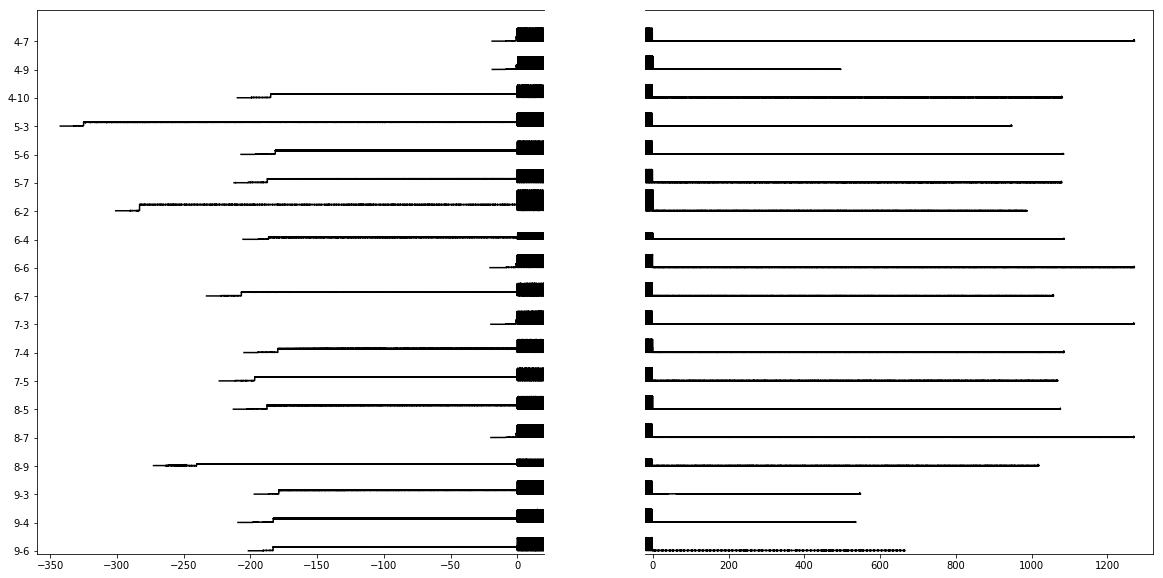

In [56]:
print('photodiode recording frequencies: ', np.round(np.min(sync_df['photodiode_freq']),2),' - ',
                                            np.round(np.max(sync_df['photodiode_freq']),2), ' Hz')

fig,axes = plt.subplots(1,2,figsize=(20,10))
# trace_buffer = 200000
plt_buffer = 200000
downsample_factor = 100


for i,r in sync_df.iterrows():
    photodiode_times = r['photodiode_times']
    photodiode = r['photodiode']
    stim_start_idx = np.max(np.where((photodiode_times-photodiode_times[0]) < 
                                     (r['first_trial_flip'] - r['signal_start_time'])))
    stim_end_idx = np.min(np.where((photodiode_times-photodiode_times[0]) > 
                                   (r['sync_end'] - r['last_trial_flip'])))
    axes[0].plot(photodiode_times[:stim_start_idx + trace_buffer:downsample_factor]-photodiode_times[stim_start_idx],
                 - i + photodiode[:stim_start_idx + plt_buffer:downsample_factor],'k')
    axes[0].set_xlim(-360,20)
    
    axes[1].plot(photodiode_times[-stim_end_idx-trace_buffer::downsample_factor]- photodiode_times[-stim_end_idx],   
                 -i + photodiode[-stim_end_idx-plt_buffer::downsample_factor] ,   'k')
    axes[1].set_xlim(-20,1320)

axes[0].set_ylim(-i-0.1,1.1)
axes[1].set_ylim(-i-0.1,1.1)
for ax in axes:
    ax.set_ylim(-i-0.1,1.1)

axes[0].set_yticks(-np.arange(len(sync_df)))
_ = axes[0].set_yticklabels(['-'.join([str(i),str(j)]) for i,j in zip(sync_df['session'],sync_df['scan_idx'])])

axes[1].set_yticks([])

axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
